In [70]:
import numpy as np
import matplotlib.pyplot as plt
from topostats.io import LoadScans
import topostats.filters as topofilters
from topostats.utils import get_mask
from pathlib import Path
from scipy.optimize import least_squares
from scipy.spatial.distance import cdist

## Easy plotting function

In [6]:
def plot(image: np.ndarray, title: str=None, zlimit: bool=True, figsize: tuple=(8, 8), **kwargs) -> None:
    fig, ax = plt.subplots(figsize=figsize)
    if zlimit == True:
        vmin=-3
        vmax=4
    else:
        vmin=None
        vmax=None
    ax.imshow(image, vmin=vmin, vmax=vmax, **kwargs)
    if title is not None:
        ax.set_title(title)
    plt.show()

## Load data

[Tue, 21 Mar 2023 12:07:58] [INFO    ] [topostats] Extracting image from Irregular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00024.spm
[Tue, 21 Mar 2023 12:07:58] [INFO    ] [topostats] Loading image from : Irregular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00024.spm
[Tue, 21 Mar 2023 12:07:58] [INFO    ] [topostats] [20230126_KPN005_25mMMgCl2_Vac_24hr.0_00024] : Loaded image from : Irregular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00024.spm
[Tue, 21 Mar 2023 12:07:58] [INFO    ] [topostats] [20230126_KPN005_25mMMgCl2_Vac_24hr.0_00024] : Extracted channel Height
[Tue, 21 Mar 2023 12:07:58] [INFO    ] [topostats] [20230126_KPN005_25mMMgCl2_Vac_24hr.0_00024] : Pixel to nm scaling : 5.992138671875


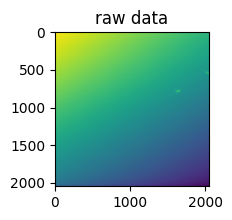

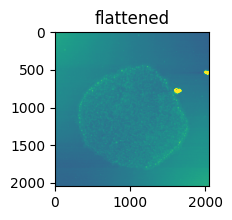

In [11]:
file = Path('./Irregular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00024.spm')
# Load the data
loadscans = LoadScans([file], channel='Height')
loadscans.get_data()
p_to_nm = loadscans.pixel_to_nm_scaling
image_raw = loadscans.image
plot(image_raw, title='raw data', zlimit=False, figsize=(2, 2))
filters = topofilters.Filters(
    image = image_raw,
    filename = file,
    pixel_to_nm_scaling = p_to_nm,
    threshold_method='std_dev',
    threshold_std_dev={'upper': 1.0, 'lower': None},
    gaussian_size=1.0,
    remove_scars={'run': False},
    quiet=True
)
filters.filter_image()
flattened = filters.images['zero_average_background']
plot(flattened, title='flattened', figsize=(2, 2))

thresholds: defaultdict(None, {'upper': 1.5992184373320717})


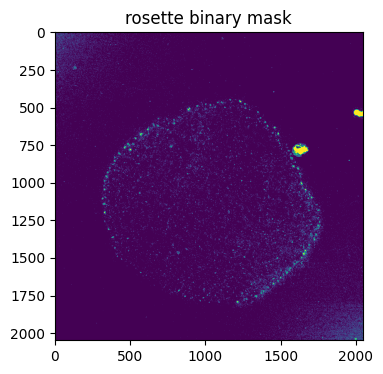

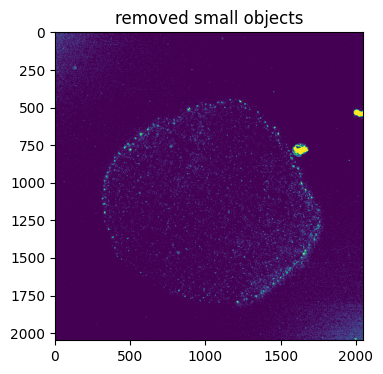

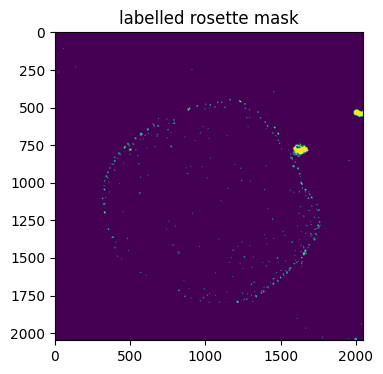

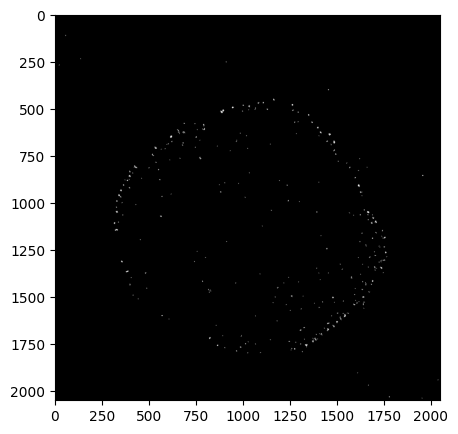

In [31]:
from skimage.morphology import remove_small_objects, label
from skimage.measure import regionprops
figsize = (4, 4)
# Get thresholds
rosette_thresholds = topofilters.get_thresholds(
    flattened,
    threshold_method='std_dev',
    threshold_std_dev={'upper': 1.5, 'lower': None}
)
print(f'thresholds: {rosette_thresholds}')
rosette_mask = topofilters.get_mask(image=flattened, thresholds=rosette_thresholds)
plot(rosette_mask.astype(bool), title='rosette binary mask', zlimit=False, figsize=figsize)

# Remove small objects
removed_small_objects = remove_small_objects(rosette_mask, 10)
plot(rosette_mask.astype(bool), title='removed small objects', zlimit=False, figsize=figsize)
# Remove large objects
labelled_rosette_mask = label(removed_small_objects)
plot(labelled_rosette_mask.astype(bool), title='labelled rosette mask', zlimit=False, figsize=figsize)
regions = regionprops(labelled_rosette_mask)
for props_index, props in enumerate(regions):
    if props.area > 100:
        labelled_rosette_mask[labelled_rosette_mask==props.label] = 0

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(labelled_rosette_mask.astype(bool), cmap='gray')

# Fit ellipse

In [28]:
def ellipse_eqn(params, x, y):
    x0, y0, a, b, theta = params
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    ellipse_x = ((x - x0) * cos_theta + (y - y0) * sin_theta) ** 2 / a ** 2
    ellipse_y = ((x - x0) * sin_theta - (y - y0) * cos_theta) ** 2 / b ** 2
    return ellipse_x + ellipse_y - 1

In [33]:
def fit_ellipse(x_data: np.ndarray, y_data: np.ndarray) -> np.ndarray:
    # Guess initial params for ellipse
    x_mean = np.mean(x_data)
    y_mean = np.mean(y_data)
    x_range = np.max(x_data) - np.min(x_data)
    y_range = np.max(y_data) - np.min(y_data)
    a_guess = x_range / 2
    b_guess = y_range / 2
    params_guess = [x_mean, y_mean, a_guess, b_guess, 0]
    # Numerically find best fitting ellipse
    result = least_squares(ellipse_eqn, params_guess, args=(x_data, y_data))

    # x0, y0, a, b, theta = params
    return result.x

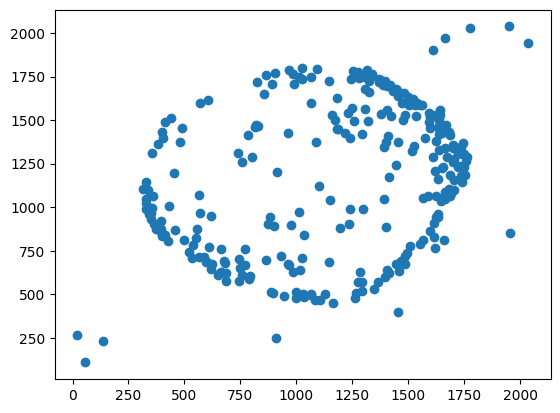

In [32]:
from skimage.measure import label, regionprops
def get_points(binary_img) -> tuple:
    labelled = label(binary_img)
    regions = regionprops(labelled)
    points = np.ndarray((len(regions), 2))
    for props_index, props in enumerate(regions):
        points[props_index, :] = props.centroid
    y_data = points[:, 0]
    x_data = points[:, 1]

    return (y_data, x_data)

y_data, x_data = get_points(labelled_rosette_mask)
plt.scatter(x_data, y_data)

In [35]:
def fit_ellipse_remove_far_points(binary_image: np.ndarray, dist_stddev_thresh_multiplier: float, fit_points: np.ndarray=None,) -> np.ndarray:
    y_data, x_data = get_points(binary_image)

    # This allows us to pass an initial ring of points to base ellipse fitting off of
    if fit_points is None:
        params = fit_ellipse(x_data, y_data)
    else:
        initial_fit_y_data, initial_fit_x_data = get_points(fit_points)
        params = fit_ellipse(initial_fit_x_data, initial_fit_y_data)

    # Plot ellipse
    x0, y0, a, b, theta = params
    t = np.linspace(0, 2 * np.pi, 100)
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    ellipse_x = x0 + a * np.cos(t) * cos_theta - b * np.sin(t) * sin_theta
    ellipse_y = y0 + a * np.cos(t) * sin_theta + b * np.sin(t) * cos_theta
    fig_fit, ax_fit = plt.subplots(1, 2, figsize=(10, 5))
    ax_fit[0].scatter(x_data, y_data)
    ax_fit[0].plot(ellipse_x, ellipse_y)
    ax_fit[0].axis('equal')
    ax_fit[0].set_aspect(1)
    ax_fit[0].invert_yaxis()
    ax_fit[0].set_title('fitted ellipse')

    # Get distances of points from ellipse
    distances = np.array([ellipse_eqn(params, x_val, y_val) for x_val, y_val in zip(x_data, y_data)])
    dist_thresh = np.mean(distances) + dist_stddev_thresh_multiplier * np.std(distances)
    # Initialise image comparison plots
    fig_img, ax_img = plt.subplots(1, 3, figsize=(14, 5))

    # Plot residuals
    ax_fit[1].scatter(x_data, distances)
    ax_fit[1].set_xlim(0, 2000)
    ax_fit[1].axhline(y=dist_thresh, color='r', linestyle='-')
    ax_fit[1].axhline(y=-dist_thresh, color='r', linestyle='-')
    ax_fit[1].set_title('residuals')

    # Remove points too far from ellipse
    too_far_indicies = np.where(abs(distances) > dist_thresh)[0]
    too_far_indicies = np.add(too_far_indicies, 1) # Add one since the label indices start from one
    print(f'too far points: {too_far_indicies}')
    # Copy arrays for posterity
    removed_too_far_points = label(binary_image.copy())
    before_removal = removed_too_far_points.copy()
    # Remove too far points
    for index in too_far_indicies:
        removed_too_far_points[removed_too_far_points==index] = 0
        circle = plt.Circle((x_data[index-1], y_data[index-1]), 50, fill=False)
        ax_img[0].add_artist(circle)
        ax_fit[1].scatter(x_data[index-1], distances[index-1], marker='.', color='r') # Sub one since point indices start from zero
        ax_fit[0].scatter(x_data[index-1], y_data[index-1], marker='.', color='r')

    # Plot results
    ax_img[0].imshow(before_removal.astype(bool))
    ax_img[0].set_title('before')
    ax_img[1].imshow(removed_too_far_points.astype(bool))
    ax_img[1].set_title('removed too far points')
    ax_img[2].imshow((removed_too_far_points - before_removal).astype(bool))
    ax_img[2].set_title('difference')
    fig_img.suptitle(f'thresh={dist_stddev_thresh_multiplier}*std_dev + mean')
    fig_img.tight_layout()
    plt.show()

    return removed_too_far_points

In [36]:
def remove_far_away_points(binary_image: np.ndarray, dist_stddev_thesh_multiplier: float) -> np.ndarray:
    plt.imshow(binary_image.astype(bool))
    plt.show()
    y_data, x_data = get_points(binary_image)
    centroid = np.array([np.mean(x_data), np.mean(y_data)])
    distances = np.array([(x_val - centroid[0])**2 + (y_val - centroid[1])**2 for x_val, y_val in zip(x_data, y_data)])
    dist_thresh = np.mean(distances) + dist_stddev_thesh_multiplier * np.std(distances)
    too_far_indices = np.where(distances > dist_thresh)[0]
    too_far_indices = np.add(too_far_indices, 1) # Add one since labels start at one
    removed_too_far_points = label(binary_image.copy())
    for index in too_far_indices:
        removed_too_far_points[removed_too_far_points==index] = 0
    plt.imshow(removed_too_far_points.astype(bool))
    
    return removed_too_far_points

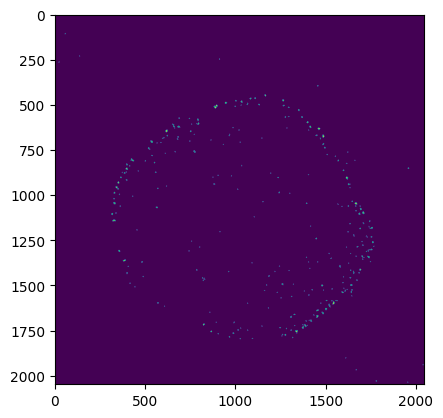

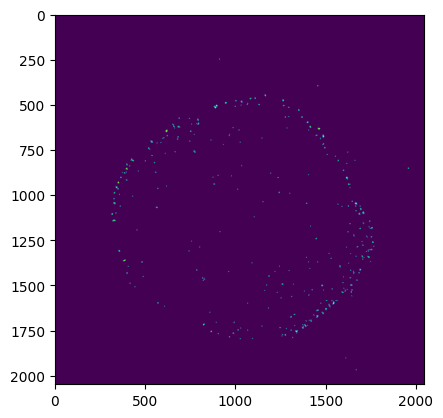

In [37]:
far_points_removed = remove_far_away_points(labelled_rosette_mask, dist_stddev_thesh_multiplier=2.0)

too far points: [  1   2  78  81  88  90  91  94  95  98 106 107 109 114 117 131 143 150
 156 162 178 181 188 190 194 195 281 282]


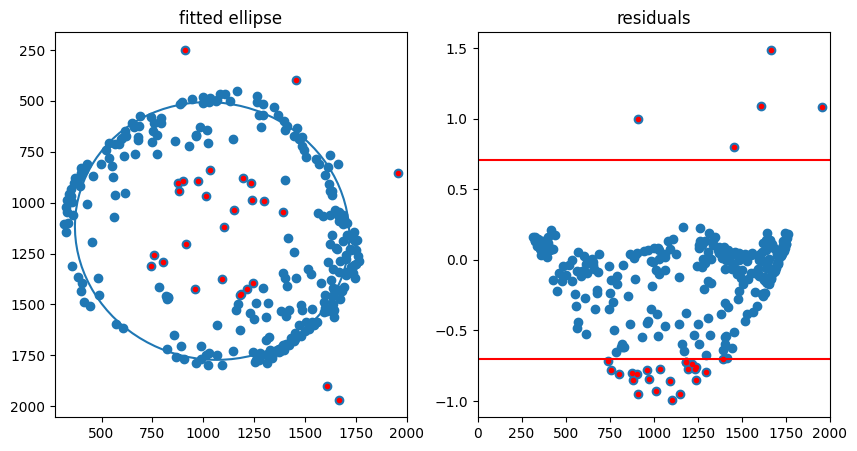

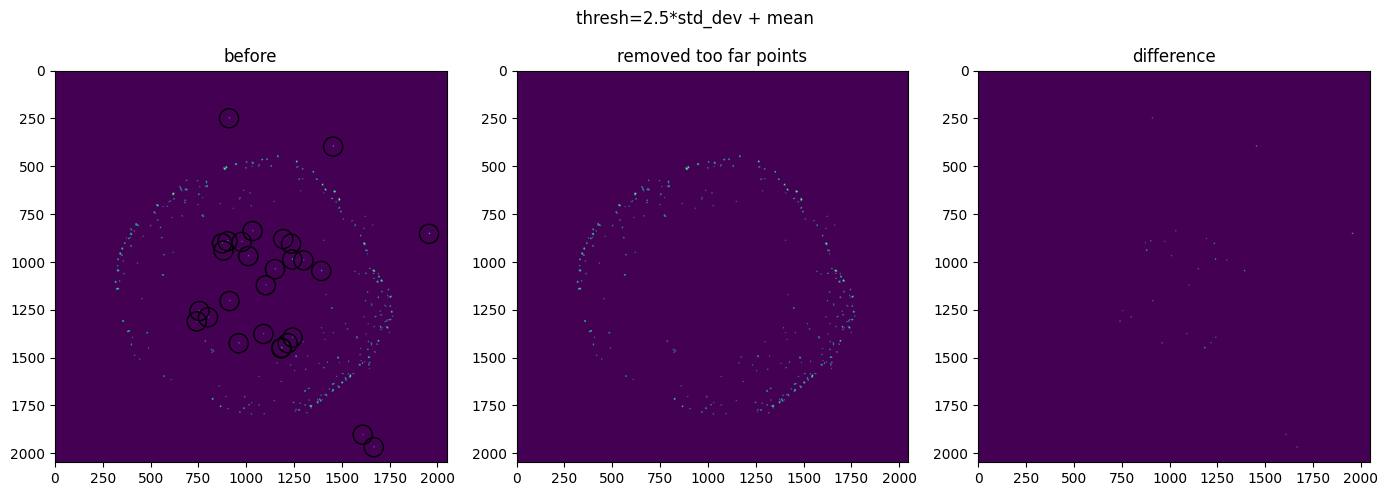

too far points: [ 45  49  52  55  59  62  84  91  94 109 120 132 144 149 156 157 161 163
 165 172 174 175 177 180 181 183 193 197 201 208]


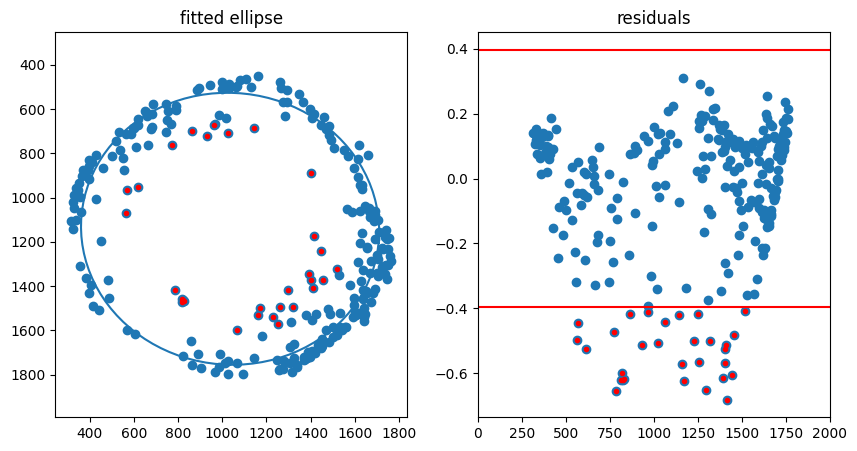

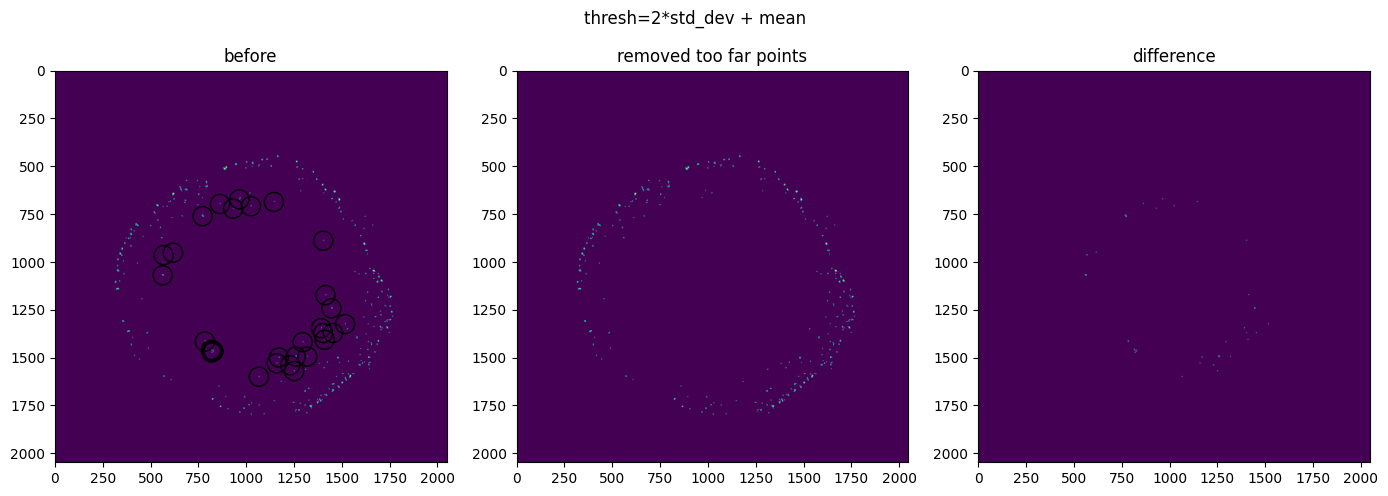

too far points: [  1   2   4  32  37  39  40  41  49  51  57  59  67  75  94  95  99 109
 114 115 124 126 137 140 141 143 158 163 164 167 170 171 172 183 187 197
 222]


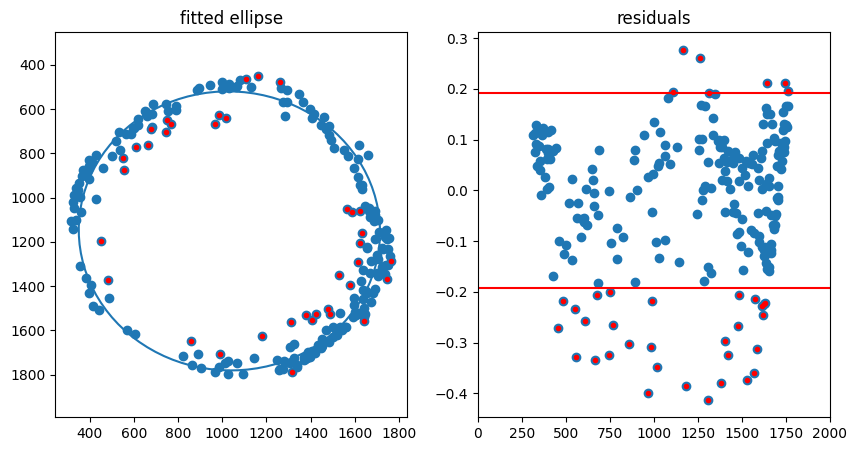

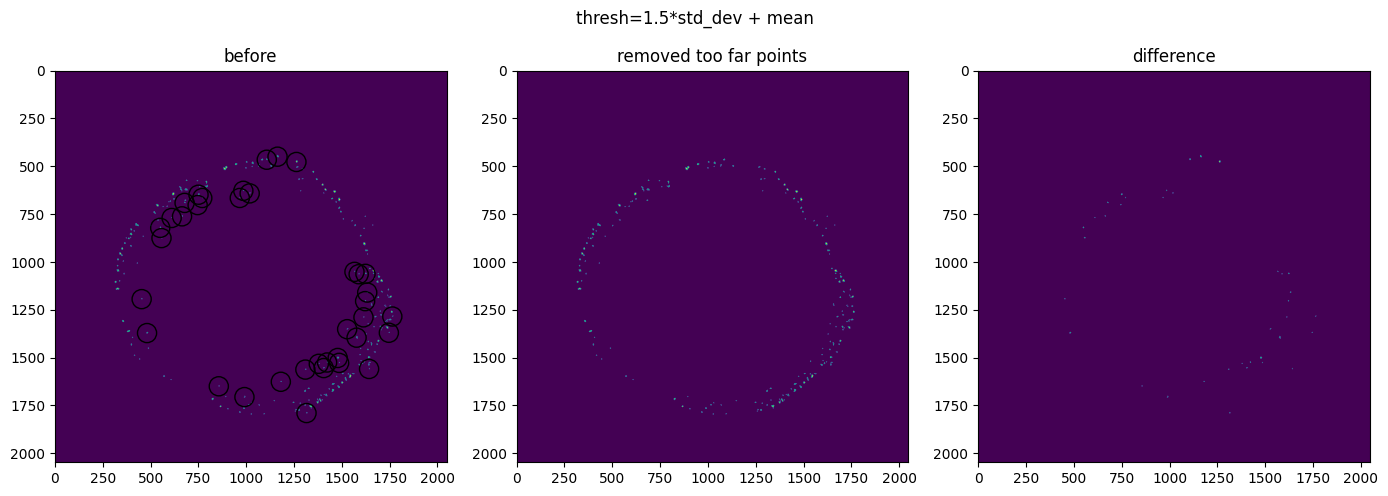

too far points: [  1  10  13  14  22  23  30  37  42  47  48  49  53  54  60  68  71  75
  77  84  96  97 102 105 110 113 117 125 134 138 153 156 162 168 172]


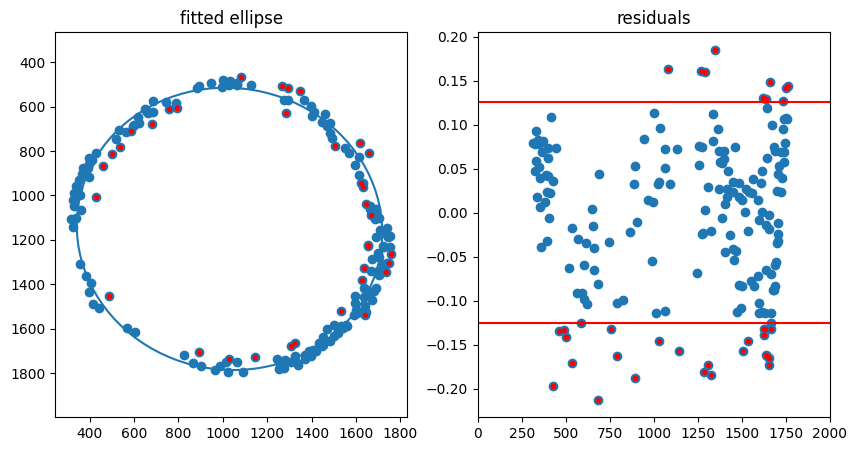

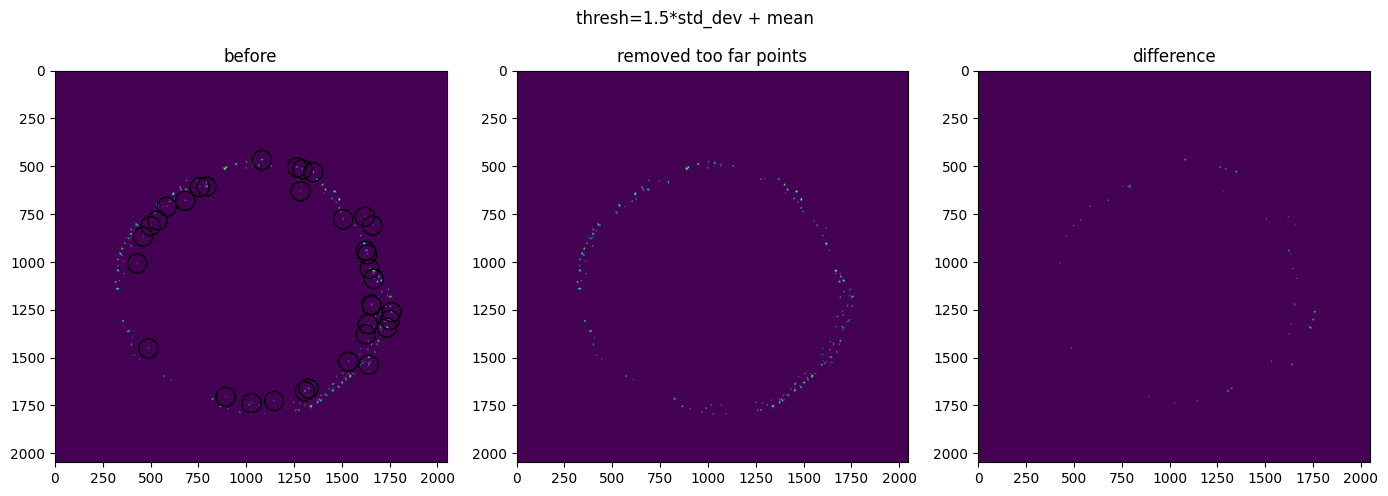

too far points: [  1   2  13  16  20  24  29  30  32  34  36  45  49  53  60  62  73  77
  81  82  98 102 108 110 116 130 139 141 145]


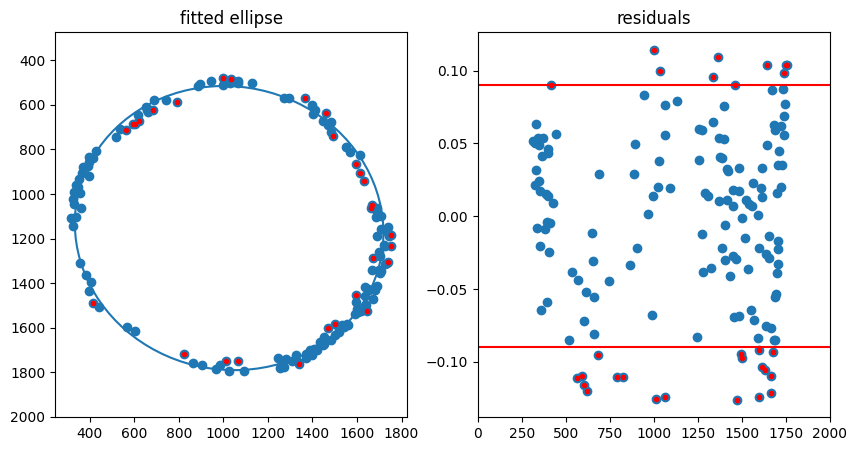

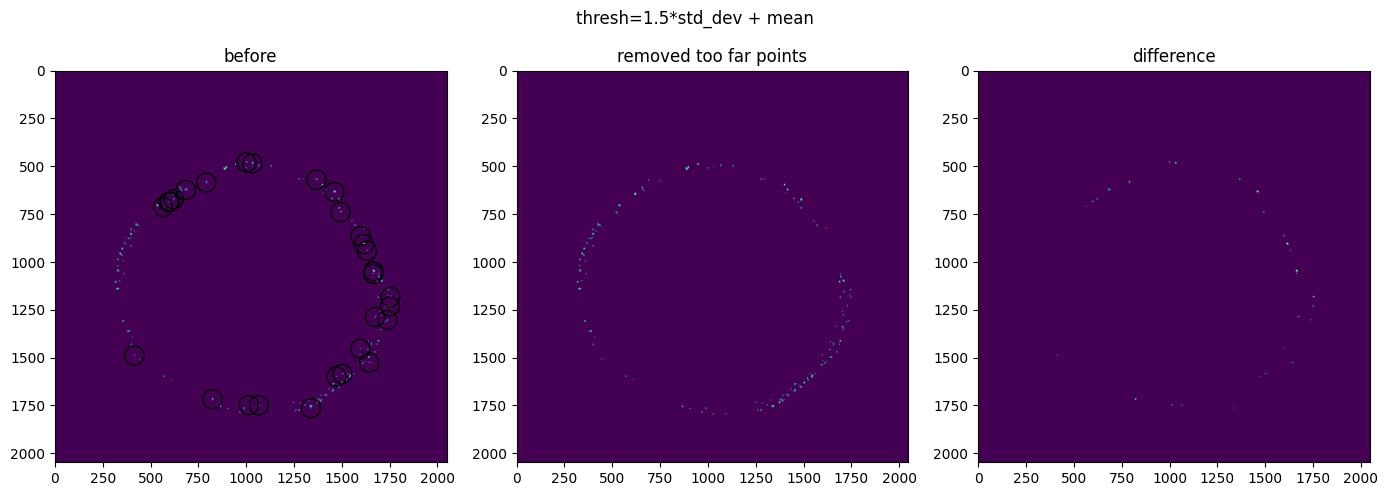

In [38]:
fitted_1 = fit_ellipse_remove_far_points(binary_image=far_points_removed, dist_stddev_thresh_multiplier=2.5)
fitted_2 = fit_ellipse_remove_far_points(binary_image=fitted_1, dist_stddev_thresh_multiplier=2)
fitted_3 = fit_ellipse_remove_far_points(binary_image=fitted_2, dist_stddev_thresh_multiplier=1.5)
fitted_4 = fit_ellipse_remove_far_points(binary_image=fitted_3, dist_stddev_thresh_multiplier=1.5)
fitted_5 = fit_ellipse_remove_far_points(binary_image=fitted_4, dist_stddev_thresh_multiplier=1.5)

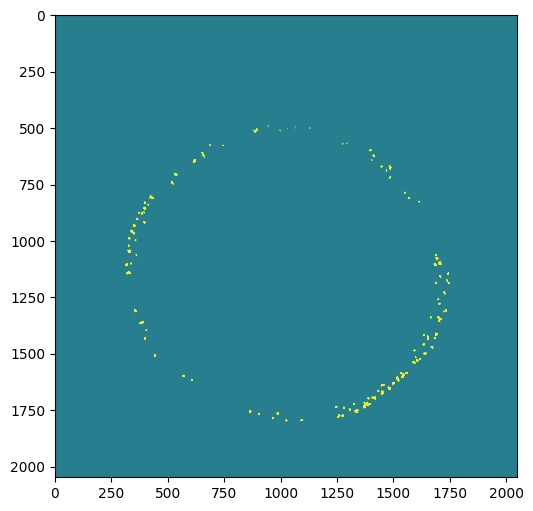

initial index: 86
found initial point after 123 steps


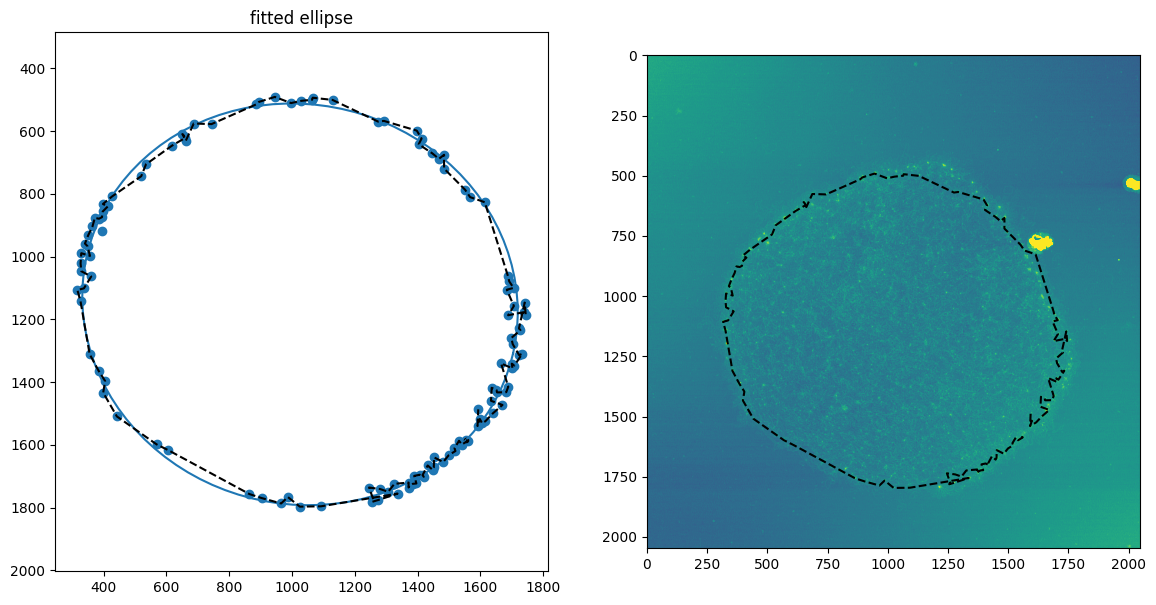

In [69]:
# Find the points in order
plot(fitted_5, figsize=(6, 6))

labelled = label(fitted_5)
regions = regionprops(labelled)
points = np.ndarray((len(regions), 2))
rosette_areas = np.zeros(len(points))
for props_index, props in enumerate(regions):
    points[props_index, :] = props.centroid
    rosette_areas[props_index] = props.area

y_data = points[:, 0]
x_data = points[:, 1]

params = fit_ellipse(x_data, y_data)
ellipse_distances = np.array([ellipse_eqn(params, x_val, y_val) for x_val, y_val in zip(x_data, y_data)])

# Plot ellipse
x0, y0, a, b, theta = params
t = np.linspace(0, 2 * np.pi, 100)
cos_theta = np.cos(theta)
sin_theta = np.sin(theta)
ellipse_x = x0 + a * np.cos(t) * cos_theta - b * np.sin(t) * sin_theta
ellipse_y = y0 + a * np.cos(t) * sin_theta + b * np.sin(t) * cos_theta
fig_fit, ax_fit = plt.subplots(1, 2, figsize=(14, 7))
ax_fit[0].scatter(x_data, y_data)
ax_fit[0].plot(ellipse_x, ellipse_y)
ax_fit[0].axis('equal')
ax_fit[0].set_aspect(1)
ax_fit[0].invert_yaxis()
ax_fit[0].set_title('fitted ellipse')

ordered_points = []
visited_indices = []
point_protection = 10
iterations = 0

# Set initial index to that of the point with least distance to the ellipse
current_index = np.argmin(np.abs(ellipse_distances))
initial_index = current_index
print(f'initial index: {initial_index}')

ax_fit[0].scatter(points[current_index, 1], points[current_index, 0], color='k', marker='.')

while True:

    if iterations == point_protection:
        visited_indices.pop(0)
    if iterations > point_protection:
        if initial_index == current_index:
            print(f'found initial point after {iterations} steps')
            break

    # Get current point
    current_point = points[current_index]
    # Add to ordered points
    ordered_points.append(current_point)
    # Calculate distances and set visited points to infinite
    distances = np.linalg.norm(points - current_point, axis=1)
    distances[visited_indices] = np.inf

    nearest_point_index = np.argmin(distances)
    current_index = nearest_point_index
    visited_indices.append(current_index)

    iterations += 1
    if iterations >= 200:
        print('DID NOT FIND ORIGINAL POINT')
        break

ordered_points = np.array(ordered_points)
xs = ordered_points[:, 1]
ys = ordered_points[:, 0]

ax_fit[1].imshow(flattened, vmin=-3, vmax=4)
ax_fit[1].plot(xs, ys, 'k--')
ax_fit[0].plot(xs, ys, 'k--')

plt.show()

# Stats calculations

In [71]:
def shoelace(points: np.ndarray):
    points = np.append(points, points[0]).reshape(-1, 2)
    area = 0
    for index in range(len(points)-1):
        matrix = points[index:index+2, :].T
        area += np.linalg.det(matrix)
    return np.round(area/2, 5)

In [72]:
def point_distances(points: np.ndarray):
    distance_matrix = cdist(points, points, 'euclidean')
    distances = distance_matrix[np.triu_indices(points.shape[0], k=1)]
    return np.round(distances, 5)

In [73]:
def polygon_perimeter(points: np.ndarray):
    points = np.append(points, points[0]).reshape(-1, 2)
    perimeter = 0
    for i in range(len(points)-1):
        point1 = points[i, :]
        point2 = points[i+1, :]
        perimeter += np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)
    return perimeter

In [74]:
def region_stats(labelled_image: np.ndarray, image: np.ndarray):

    region_props = regionprops(label_image=labelled_image)
    areas = np.zeros(len(region_props))
    volumes = np.zeros(len(region_props))
    for props_index, props in enumerate(region_props):
        areas[props_index] = props.area
        region_points = np.where(labelled_image == props.label)
        region_values = image[region_points]
        volume = np.sum(region_values)
        volumes[props_index] = volume

    return {
        'areas': areas,
        'volumes': volumes,
        'number_of_regions': len(region_props)
    }

number of nodes in perimeter: 123
total object area: 48.91336994821617 μm^2
mean distance between edge points: 4.893877330919041 μm
perimeter: 35.54430833343744 μm
mean node area: 0.0011063634229324698 μm^2
mean node volume: 0.0025236234505135757 μm^3


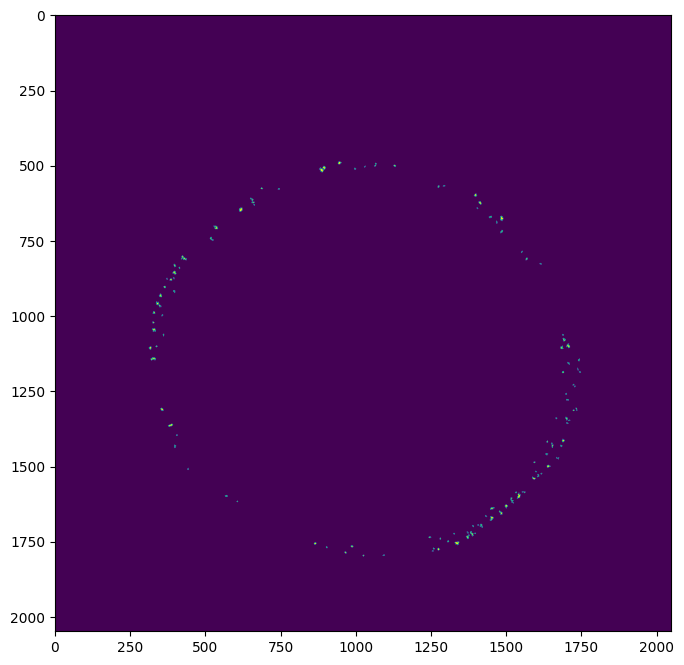

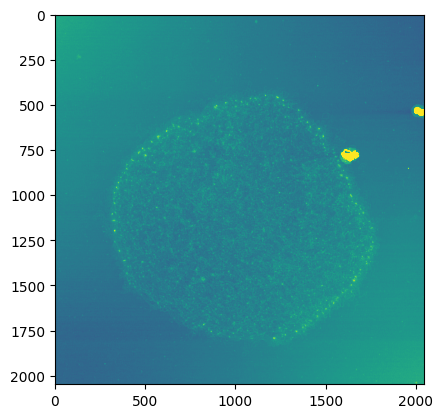

In [82]:
MICRON_SCALING_FACTOR = 0.001
P_TO_MICRON = p_to_nm * MICRON_SCALING_FACTOR

num_perimeter_nodes = ordered_points.shape[0]
print(f'number of nodes in perimeter: {num_perimeter_nodes}')
area = shoelace(sorted) * P_TO_MICRON**2
print(f'total object area: {area} μm^2')
mean_edge_point_distance = np.mean(point_distances(sorted)) * P_TO_MICRON
print(f'mean distance between edge points: {mean_edge_point_distance} μm')
perimeter = polygon_perimeter(sorted) * P_TO_MICRON
print(f'perimeter: {perimeter} μm')

# WATERSHED FOR ACCURATE AREA AND VOLUME STATS?

region_statistics = region_stats(labelled_image=labelled, image=flattened)
areas = region_statistics['areas'] * P_TO_MICRON**2
print(f'mean node area: {np.mean(areas)} μm^2')
volumes = region_statistics['volumes'] * P_TO_MICRON**2
print(f'mean node volume: {np.mean(volumes)} μm^3')

fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(labelled.astype(bool))
plt.show()
plt.imshow(flattened, vmin=-3, vmax=4)